In [241]:
%load_ext autoreload
%autoreload 2
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import datetime
import pandas as pd
import itertools
import sys
import os
import math
sys.path.append('../..')
import scipy.optimize as opt
from joblib import Parallel, delayed
from functools import partial
from hyperopt import hp, tpe, fmin, Trials
from models.optim.sir_simple import SIR

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def calculate_opt(intervention_day, intervention_duration, intervention_choice, days):
    R0 = 3 
    T_treat = 50
    T_trans = T_treat/R0

    N = 1e5
    I0 = 100.0

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    
    params = [T_trans, T_treat, N, intervention_day, intervention_duration, intervention_choice]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, I0/N, 0]
    
    solver = SIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    
    S_coeficeint=0
    I_coeficeint=1
    R_coeficeint=0
    
    
    coeficeint=[S_coeficeint,I_coeficeint,R_coeficeint]
    
    for i in range(days):
        grad1 = np.dot(coeficeint,np.sum(states_int_array/N, axis=1))
    return(grad1, states_int_array/N)

In [243]:
grad1, states_base = calculate_opt(intervention_day=np.array([100]), intervention_duration=np.array([50]), intervention_choice=np.array([0]), days=500)
print(grad1)

46.729110000000006


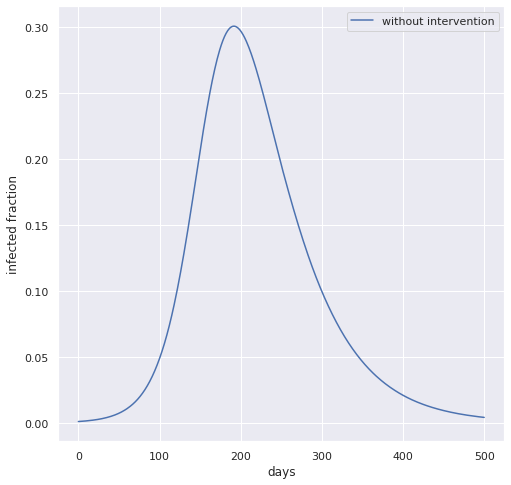

In [245]:
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8,8))
plt.plot(ind, states_base[1], label='without intervention')
plt.ylabel('infected fraction')
plt.xlabel('days')
plt.legend()
plt.show()

In [207]:
def check(start_array, duration_array, choice_array, total_resource):
    for i in range(1,len(start_array)):
        if(start_array[i] <= start_array[i-1] + duration_array[i-1]):
            return(0)
    resource_spent = np.dot(duration_array, choice_array)
    if(resource_spent != total_resource):
        return(0)
    else:
        return(1)

# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def calculate_opt_val(intervention_day, intervention_duration, intervention_choice, days):
    R0 = 3 
    T_treat = 50
    T_trans = T_treat/R0

    N = 1e5
    I0 = 100.0

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    
    params = [T_trans, T_treat, N, intervention_day, intervention_duration, intervention_choice]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, I0/N, 0]
    
    solver = SIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    
    S_coeficeint=0
    I_coeficeint=1
    R_coeficeint=0
    
    
    coeficeint=[S_coeficeint,I_coeficeint,R_coeficeint]
    
    for i in range(days):
        grad1 = np.dot(coeficeint,np.sum(states_int_array/N, axis=1))
    return(grad1)

def grid_search(num_int, total_resource=60, day0=10):
    min_val = 100
    min_params = {}
    params = []
    min_duration = 10
    max_duration = total_resource*np.array([4,2,1])
   
    if(num_int == 1):
        start_val = [start for start in range(day0, day0+365, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 5)]
        start_tuple = list(itertools.product(start_val))
        choice_tuple = list(itertools.product(choice_val))
        duration_tuple = list(itertools.product(duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource)):
                params.append([start_array, choice_array, duration_array])
        
    if(num_int == 2):
        start_val = [start for start in range(day0, day0+365, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 5)]
        start_tuple = list(itertools.product(start_val, start_val))
        choice_tuple = list(itertools.product(choice_val, choice_val))
        duration_tuple = list(itertools.product(duration_val, duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource)):
                params.append([start_array, choice_array, duration_array])
            
    if(num_int == 3):
        start_val = [start for start in range(day0, day0+365, 50)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource, 20)]
        start_tuple = list(itertools.product(start_val, start_val, start_val))
        choice_tuple = list(itertools.product(choice_val, choice_val, choice_val))
        duration_tuple = list(itertools.product(duration_val, duration_val, duration_val))
        inputs = list(itertools.product(start_tuple, duration_tuple, choice_tuple))
        for inp in inputs:
            start_array = np.array(inp[0])
            duration_array = np.array(inp[1])
            choice_array = np.array(inp[2])
            if(check(start_array, duration_array, choice_array, total_resource)):
                params.append([start_array, choice_array, duration_array])
        
                            
    print(len(params))

    value_array = Parallel(n_jobs=40)(delayed(calculate_opt_val)(intervention_day=par[0], intervention_duration=par[2],\
                                                             intervention_choice=par[1], days = 500) for par in params)
    value_array = np.array(value_array)
    min_val = np.min(value_array)
    i = np.argmin(value_array)
    min_params['start_array'] = params[i][0]
    min_params['duration_array'] = params[i][2]
    min_params['choice_array'] = params[i][1]
    
    return(min_val, min_params)    

74
41.177960000000006


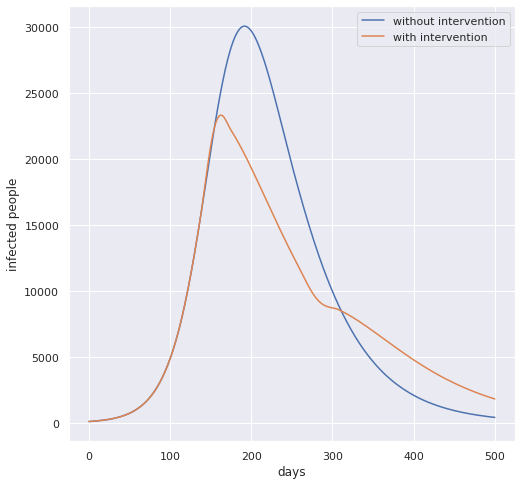

In [200]:
#num_int = 1
min_val, min_params = grid_search(num_int=1)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=500)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='with intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

67015
38.92756


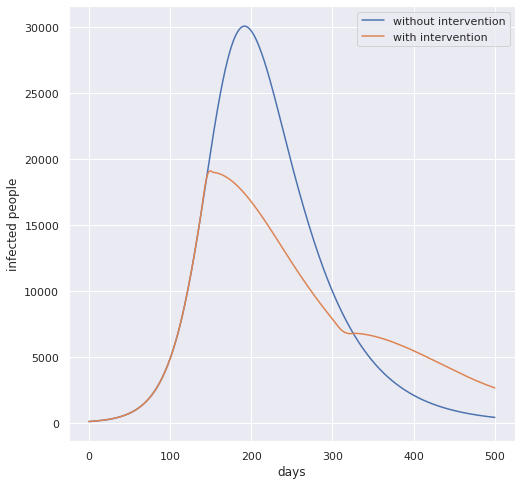

In [202]:
# num_int = 2
min_val, min_params = grid_search(num_int=2)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=500)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='with intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

5244
40.09061


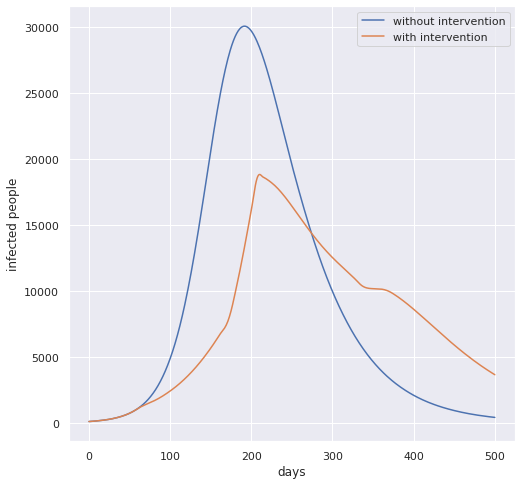

In [208]:
#num_int = 3
min_val, min_params = grid_search(num_int=3)
print(min_val)
val, states = calculate_opt(intervention_day=min_params['start_array'], intervention_duration=min_params['duration_array'],\
              intervention_choice=min_params['choice_array'], days=500)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='with intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

In [211]:
def check(start_array, duration_array, choice_array, total_resource):
    for i in range(1,len(start_array)):
        if(start_array[i] <= start_array[i-1] + duration_array[i-1]):
            return(0)
    resource_spent = np.dot(duration_array, choice_array)
    if(resource_spent != total_resource):
        return(0)
    else:
        return(1)

# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def mod_calculate_opt(variable_params, total_resource, days):
    R0 = 3 
    T_treat = 50
    T_trans = T_treat/R0

    N = 1e5
    I0 = 100.0

    intervention_day = np.array(variable_params['intervention_day'])
    intervention_duration = np.array(variable_params['intervention_duration'])
    intervention_choice = np.array(variable_params['intervention_choice'])

    assert(len(intervention_day) == len(intervention_duration))
    assert(len(intervention_duration) == len(intervention_choice))
    if(not check(intervention_day, intervention_duration, intervention_choice, total_resource)):
        return(100)
    
    params = [T_trans, T_treat, N, intervention_day, intervention_duration, intervention_choice]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, I0/N, 0]
    
    solver = SIR(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    
    S_coeficeint=0
    I_coeficeint=1
    R_coeficeint=0
 
    coeficeint=[S_coeficeint,I_coeficeint,R_coeficeint]
    
    for i in range(days):
        grad1 = np.dot(coeficeint,np.sum(states_int_array/N, axis=1))
        
    return(grad1)

def tpe_opt(num_int, total_resource=30, day0=30):
    if(num_int==1):
        start_val = [start for start in range(day0, day0+365, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource+1, 5)]

        variable_params = {
            'intervention_day' : [hp.choice('intervention_day', start_val)],
            'intervention_duration' : [hp.choice('intervention_duration', duration_val)],
            'intervention_choice' : [hp.choice('intervention_choice', choice_val)],
        }
        
    if(num_int==2):
        start_val = [start for start in range(day0, day0+365, 10)]
        choice_val = [0.25, 0.5, 1]
        duration_val = [duration for duration in range(10, 4*total_resource+1, 5)]

        variable_params = {
            'intervention_day' : [hp.choice('id_0', start_val),hp.choice('id_1', start_val)],
            'intervention_duration' : [hp.choice('du_0', duration_val),hp.choice('du_1', duration_val)],
            'intervention_choice' : [hp.choice('ic_0', choice_val),hp.choice('ic_1', choice_val)],
        }

    partial_calculate_opt = partial(mod_calculate_opt, total_resource=total_resource, days=400) 
    
    searchspace = variable_params
    
    trials = Trials()
    best = fmin(partial_calculate_opt,
                space=searchspace,
                algo=tpe.suggest,
                max_evals=3000,
                trials=trials)
    
    return(best, trials)

In [212]:
tpe_opt(num_int=1)

100%|██████████| 3000/3000 [01:25<00:00, 34.99trial/s, best loss: 41.66293]         


({'intervention_choice': 1,
  'intervention_day': 13,
  'intervention_duration': 10},
 <hyperopt.base.Trials at 0x7f994aeb8518>)

In [213]:
tpe_opt(num_int=2)

100%|██████████| 3000/3000 [01:25<00:00, 35.16trial/s, best loss: 42.99898999999999] 


({'du_0': 0, 'du_1': 2, 'ic_0': 2, 'ic_1': 2, 'id_0': 12, 'id_1': 18},
 <hyperopt.base.Trials at 0x7f994ae61048>)

## Heuristic Based Method

In [229]:
from models.optim.sir_cont import SIR as SIR_CONT
# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def run_seir(days, int_vec):
    R0 = 3 
    T_treat = 50
    T_trans = T_treat/R0

    N = 1e5
    I0 = 100.0
    
    params = [T_trans, T_treat, N, int_vec]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, I0/N, 0]
    
    solver = SIR_CONT(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    derivatives = np.ones((days,3))
    for t in range(days):
        derivatives[t] = solver.get_derivative(t=t, y=states_int_array[:,t])
    
    S_coeficeint=0
    I_coeficeint=1
    R_coeficeint=0
    
    coeficeint=np.array([S_coeficeint,I_coeficeint,R_coeficeint])
    
    grad1 = np.ones(days)
    grad2 = np.ones(days)

    for i in range(days):
        grad2[i] = np.dot(coeficeint,(derivatives[i]/N))
        grad1[i] = np.dot(coeficeint,(states_int_array[:,i]/N))
    return(grad1,states_int_array)

In [220]:
total_resource = 120
resource_spent = 0
window = 5
int_vec = np.ones(500)
while(resource_spent<total_resource):
    curve, states = run_seir(days=500, int_vec=int_vec)
    arg_curve = (-curve).argsort()
    day_max = arg_curve[0]
    i=1
    while(int_vec[day_max]>=3):
        day_max = arg_curve[i]
        i += 1

    int_vec[day_max] += 0.25 
    resource_spent += 0.25

In [221]:
int_vec

array([1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  , 1.  ,
       1.  , 3.  , 3.  , 3.  , 3.  , 3.  , 3.  , 3.

In [222]:
curve, states = run_seir(days=500, int_vec=int_vec)
print(np.sum(curve))

43.92736


In [255]:
curve_base, states_base = run_seir(days = 500, int_vec=np.ones(500))
np.sum(curve_base)

46.72498

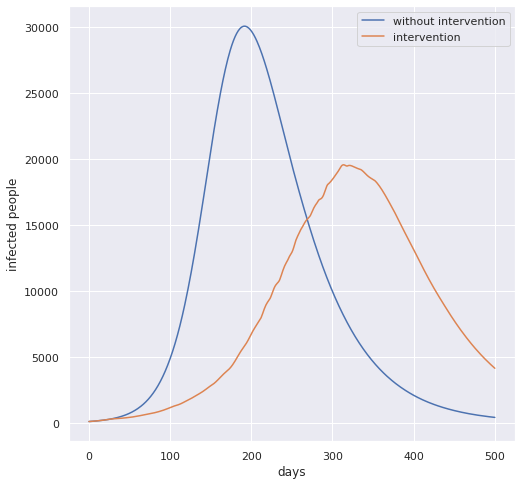

In [256]:
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8,8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

## Smart Heuristic Algorithm

In [250]:
def get_overlap(ps,pe,s,e):
    if(s>pe or e<ps):
        return(0)
    else:
        max_s = max(ps,s)
        min_e = min(pe,e)
        return(min_e - max_s + 1)
    
def get_dist(tup1, tup2):
    return(abs(sum(tup1)-sum(tup2)))

def shift(ps,pe,s,e):
    if(ps+pe > s+e):
        return(e+1,pe+e-ps+1)
    else:
        return(ps+s-pe-1,s-1)

def check_overlap(p_time, int_list):
    if(not len(int_list)):
        return(p_time)
    elif(len(int_list)<5 and len(int_list)>=1):
        (ps, pe) = p_time
        max_overlap = 0
        mo_s, mo_e = 0, 0
        for i in range(len(int_list)):
            s, e = int_list[i]
            overlap = get_overlap(ps,pe,s,e)
            if(overlap>5):
                return((s,e))
            if(overlap>max_overlap):
                max_overlap = overlap
                mo_s, mo_e = s, e
                
        if(max_overlap==0):
            return((ps,pe))
        else:
            ns, ne = shift(ps,pe,mo_s,mo_e)
            if(ns<30):
                return((mo_s,mo_e))
            for i in range(len(int_list)):
                s, e = int_list[i]
                overlap = get_overlap(ns,ne,s,e)
                if(overlap>0):
                    return((mo_s,mo_e))
            return((ns,ne))
        
    else:
        min_dist = 500
        min_dist_s = 0
        min_dist_e = 0
        for i in range(len(int_list)):
            dist = get_dist(p_time, int_list[i])
            if(dist<min_dist):
                min_dist_s, min_dist_e = int_list[i]
        return((min_dist_s,min_dist_e))
    

In [251]:
total_resource = 120
resource_spent = 0
min_d = 10
init_day = 10
max_num_int = 5
int_vec = np.ones(500)
interventions = []
while(resource_spent<total_resource):
    curve, states = run_seir(days=500, int_vec=int_vec)
    arg_curve = (-curve).argsort()
    day_max = arg_curve[0]
    i=1
    while(day_max<init_day or int_vec[day_max]>=2):
        day_max = arg_curve[i]
        i += 1

    buffer = day_max - init_day
    if(buffer<min_d/2):
        (start,end) = check_overlap((init_day, init_day+min_d),interventions)
    else:
        (start,end) = check_overlap((day_max-min_d/2+1, day_max+min_d/2),interventions)
        
    start, end = int(start), int(end)
    
    if(int_vec[start]==1):
        int_vec[start:end+1] = 1.5
        resource_spent += 2.5
    elif(int_vec[start]==1.5):
        int_vec[start:end+1] = 2
        resource_spent += 2.5
    else:
        int_vec[start:end+1] = 3
        resource_spent += 5 
    if((start,end) not in interventions):
        interventions.append((start,end))

In [252]:
int_vec

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

45.09167


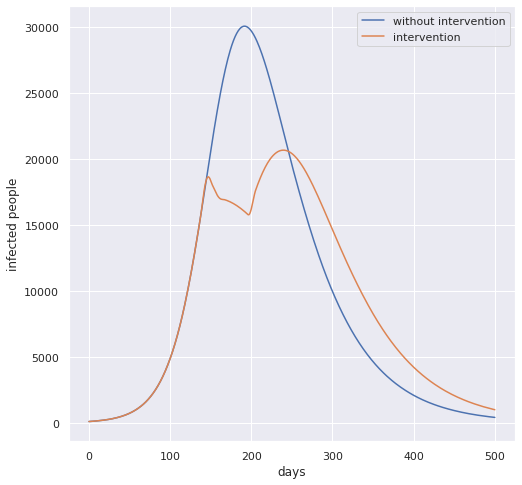

In [257]:
curve, states = run_seir(days=500, int_vec=int_vec)
print(np.sum(curve))
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

## Gradient Based Methods

In [230]:
import sys
sys.path.append('../..')
from models.optim.sir_cont import SIR as SIR_CONT
# np.array([start days]), np.array([duration]), np.array([choice], number_of_days_simulated)
def run_seir_grad(days, int_vec):
    R0 = 3 
    T_treat = 50
    T_trans = T_treat/R0

    N = 1e5
    I0 = 100.0
    
    params = [T_trans, T_treat, N, int_vec]

    # S, E, I, R_mild, R_severe, R_severe_home, R_fatal, C, D
    state_init_values = [(N - I0)/N, I0/N, 0]
    
    solver = SIR_CONT(params, state_init_values)
    sol = solver.solve_ode(time_step=1, total_no_of_days=days)
    states_int_array = (sol.y*N).astype('int')
    
    derivatives = np.ones((days,3))
    for t in range(days):
        derivatives[t] = solver.get_derivative(t=t, y=states_int_array[:,t])
    
    S_coeficeint=0
    I_coeficeint=1
    R_coeficeint=0
    
    coeficeint=np.array([S_coeficeint,I_coeficeint,R_coeficeint])
    
    grad1 = np.ones(days)
    grad2 = np.ones(days)

    for i in range(days):
        grad2[i] = np.dot(coeficeint,(derivatives[i]/N))
        grad1[i] = np.dot(coeficeint,(states_int_array[:,i]/N))
    return(grad1)

### Getting gradients wrt int_vec

In [231]:
def get_grad(int_vec):
    days = len(int_vec)
    num_pts = 3  # number of points used for derievative.
    grad_vec = np.ones(days)
    for i in range(10, days):
    #     i represents the ith dimension of T_transi
        val = int_vec[i]
        window_size = 0.005
        values = np.random.uniform(val-window_size, val+window_size, num_pts)
        f_values = np.ones_like(values)
        for j,value in enumerate(values):
            int_vec[i] = value
            f_values[j] = np.sum(run_seir_grad(days, int_vec))
        values = np.append(values,val)
        int_vec[i] = val
        fval = np.sum(run_seir_grad(days, int_vec))
        f_values = np.append(f_values,fval)
        derivative = np.gradient(f_values, values, edge_order=2)
        grad_vec[i] = derivative[-1]
    return(grad_vec)

### Formulating optimization problem

In [247]:
from pulp import *
def opt_step(grad):
    prob = LpProblem("Minimization over constrained space",LpMinimize)

    day_list = list((np.arange(500-10)).astype(str))

    int_days = LpVariable.dicts("day",day_list,lowBound=1,upBound=3,cat='Continuous')

#     grad = get_grad(np.ones(400))

    prob += lpSum([grad[int(i)]*int_days[i] for i in day_list]) #objective function
    prob += lpSum([int_days[f] for f in day_list]) <= 620.0-10.0 #TotalResource
    prob.solve()
    opt_val = np.ones(500)
    for v in prob.variables():
        idx = v.name.split('_')[-1]
        opt_val[int(idx)+10] = v.varValue
        
    return(opt_val)

### Adding constraints

In [5]:
def l2_diff(int_days, day_list):
    ret_val = []
    for day in day_list:
        if(day!='399'):
            val = int_days[str(int(day)+1)] - int_days[day]
            ret_val.append(val)
    return(ret_val)

In [6]:
# prob += lpSum([int_days[f] for f in day_list]) <= 430.0 #"TotalResource"
# diff_arr = l2_diff(int_days,day_list)
# prob += lpSum(diff_arr) <= 5 #"NumInterventions"

### Frank-Wolfe algo

In [248]:
num_iter = 100
best_val = 50
int_vec = np.ones(500)
best_int_vec = np.ones(500)
for i in range(num_iter):
    gradient = get_grad(int_vec)
    opt = opt_step(gradient)
    gamma = 2.0/(3+i)
    int_vec = int_vec + gamma*(opt-int_vec)
    value = np.sum(run_seir_grad(int_vec=int_vec,days=500))
    print(value)
    if(value < best_val):
        best_val = value
        best_int_vec = int_vec
print(best_val)

/home/users/bhardwaj/env_covid/lib/python3.7/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


46.814510000000006
46.504760000000005
45.76509
44.175259999999994
44.62788
44.632419999999996
44.16736
43.212520000000005
44.07473
43.39667
43.29733
43.800839999999994
42.99962
43.69764
43.658739999999995
43.04599
42.9004
43.48589
43.054429999999996
43.36838
43.61913
43.36122
43.25328
43.14296
43.18035
43.1032
43.242670000000004
43.18235
43.065169999999995
43.3937
42.4362
42.95908
42.68186
42.90412
42.80774
42.804230000000004
43.08735
42.73028
43.08527
42.69495
42.881510000000006
42.86707
42.74616
42.75967
42.430859999999996
42.89122999999999
42.6991
42.695609999999995
42.996309999999994
42.60481
42.98758
42.50481
42.488420000000005
42.15318
42.98189
42.833239999999996
42.52175
43.22073
42.5396
43.18185
42.89081
42.57896
42.42364
42.76735
42.67986
42.57414
42.67322000000001
43.14201
42.52307999999999
42.75294
42.708650000000006
42.84209
42.37249
42.729820000000004
42.69687999999999
42.4536
42.933730000000004
42.75538
42.98562
42.84872
42.4778
42.841570000000004
42.931430000000006
42.78

42.148920000000004


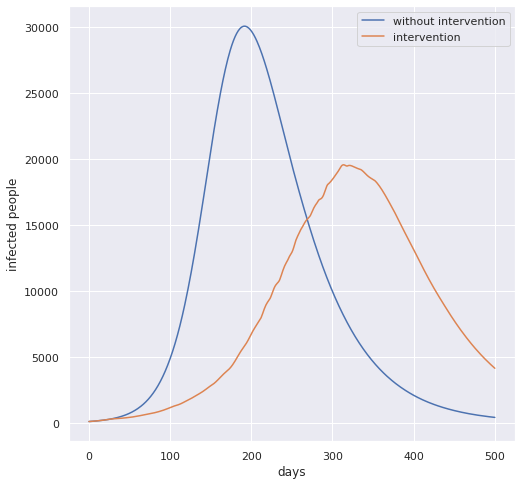

In [258]:
print(best_val)
curve, states = run_seir(days=500, int_vec=best_int_vec)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

### Discretize FW results

In [266]:
int_vec = best_int_vec.copy()
int_vec[int_vec<1.25]=1
int_vec[np.logical_and(int_vec<1.75, int_vec>1.25)] = 1.5
int_vec[int_vec>1.75] = 2

In [267]:
int_vec

array([1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1. , 1. , 1. , 1. , 2. , 1. , 2. , 1. , 1. , 2. , 1.5, 1.5, 1.5,
       1.5, 2. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1. , 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 2. , 2. , 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 2. , 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1. , 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1. , 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5,
       1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.5, 1.

In [270]:
num=0
for i in range(len(int_vec)):
    if(num>=3):
        break
    if(int_vec[-i]==1.5):
        int_vec[-i]=1
        num+=1
print(np.sum(int_vec))

620.0


In [269]:
np.sum(best_int_vec)

619.9021223470661

43.33976


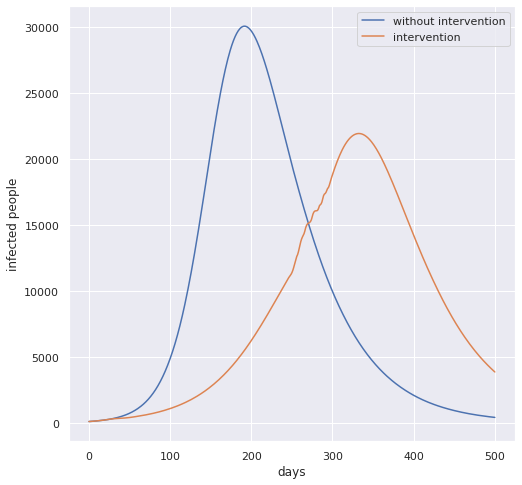

In [272]:
curve, states = run_seir(days=500, int_vec=int_vec)
best_dis_val = np.sum(curve)
print(best_dis_val)
ind = np.arange(501)   # the x locations for the groups
width = 0.95        # the width of the bars: can also be len(x) sequence
plt.figure(figsize=(8, 8))
plt.plot(ind, states_base[1], label='without intervention')
plt.plot(ind, states[1], label='intervention')
plt.ylabel('infected people')
plt.xlabel('days')
plt.legend()
plt.show()

## RL Based approach

In [77]:
from models.optim.sir_discrete import SIR_Discrete
from sklearn.ensemble import ExtraTreesRegressor
import pickle
import time
from tqdm import tqdm, trange
import math

In [78]:
def is_fitted(sklearn_regressor):
    """Helper function to determine if a regression model from scikit-learn has
    ever been `fit`"""
    return hasattr(sklearn_regressor, 'n_outputs_')

In [79]:
class FittedQIteration(object):
    def __init__(self, regressor=None):
        """Initialize simulator and regressor. Can optionally pass a custom
        `regressor` model (which must implement `fit` and `predict` -- you can
        use this to try different models like linear regression or NNs)"""
        self.simulator = SIR_Discrete()
        self.regressor = regressor or ExtraTreesRegressor()

    def Q(self, states):
        """Return the Q function estimate of `states` for each action"""
        if not is_fitted(self.regressor):
            # If not fitted, return 0s in the right shape
            return np.zeros((len(states), self.simulator.num_actions))
        else:
            # Otherwise use the trained regression model
            return np.array([self.regressor.predict(self.encode(states, action))
                             for action in range(self.simulator.num_actions)]).T

    def policy(self, state, eps=0.1):
        """Return the epsilon-greedy action based on the current policy (or a
        random action if the Q function hasn't yet been estimated."""
        if np.random.rand() < eps or not is_fitted(self.regressor):
            return np.random.choice(self.simulator.num_actions)
        else:
            return self.Q([state]).argmax()

    def run_episode(self, eps=0.1, episode_length=200):
        """Run a single episode on the HIV simulator using the current policy.
        Can pass a custom `eps` to test out varying levels of randomness.
        Return the states visited, actions taken, and rewards received."""
        S = np.zeros((episode_length+1, self.simulator.num_states))
        A = np.zeros(episode_length)
        R = np.zeros(episode_length)

        self.simulator.reset()
        S[0] = self.simulator.STATE

        for t in range(episode_length):
            A[t] = self.policy(S[t], eps=eps)
            R[t], S[t+1] = self.simulator.perform(A[t])
        return S, A, R

    def fit_Q(self, episodes, num_iters=100, discount=0.98,episode_length=200):
        """Fit and re-fit the Q function using historical data for the
        specified number of `iters` at the specified `discount` factor"""
        S1 = np.vstack([ep[0][:-1] for ep in episodes])
        S2 = np.vstack([ep[0][1:] for ep in episodes])
        A = np.hstack([ep[1] for ep in episodes])
        R = np.hstack([ep[2] for ep in episodes])
        inputs = self.encode(S1, A)
        progress = tqdm(range(num_iters), file=sys.stdout,desc='num_iters')
        for _ in range(num_iters):
            progress.update(1)
            targets = R + discount * self.Q(S2).max(axis=1)
            self.regressor.fit(inputs, targets)
        progress.close()
    def fit(self, num_refits=10, num_episodes=15, episode_length=200, save=False):
        """Perform fitted-Q iteration. For `outer_iters` steps, gain
        `num_episodes` episodes worth of experience using the current policy
        (which is initially random), then fit or re-fit the Q-function. Return
        the full set of episode data."""
        episodes = []
        progress = tqdm(range(num_refits), file=sys.stdout,desc='num_refits')
        for i in range(num_refits):
            progress.update(1)
            for _ in range(num_episodes):
                episodes.append(self.run_episode(episode_length=episode_length))
            self.fit_Q(episodes=episodes, episode_length=episode_length)
            if save:
                with open('./fqi-regressor-iter-{}.pkl'.format(i+1), 'wb') as f:
                    pickle.dump(self.regressor, f)
        progress.close()
        return episodes

    def encode(self, states, actions):
        """Encode states and actions as a single input array, suitable for
        passing into the `fit` method of a scikit-learn model."""
        if isinstance(actions, int):
            actions = [actions] * len(states)
        actions = np.array([[a] for a in actions])
        states = np.array(states)
        return np.hstack([states, actions])

In [80]:
def run_rl():
    num_refits=10
    num_episodes=15
    episode_length=400
    env=FittedQIteration()
    episodes=env.fit( num_refits=num_refits, num_episodes=num_episodes,episode_length=episode_length)

    discount=0.98
    real_episodes=env.run_episode(eps=0,episode_length=episode_length)
    S=real_episodes[0]
    A=real_episodes[1]
    R=real_episodes[2]
    best_r=0
    for i in range(len(R)):
        best_r+=R[i]*(discount**i)


    random_action_episodes=env.run_episode(eps=1,episode_length=episode_length)
    S_r=random_action_episodes[0]
    A_r=random_action_episodes[1]
    R_r=random_action_episodes[2]
    random_r=0
    for i in range(len(R_r)):
        random_r+=R_r[i]*(discount**i)
    test_r=0    

    state=real_episodes[0][0]

    estimate_r=env.Q([state])[0]
    print("Estimate Reward(Discounted):")
    print(max(estimate_r))
    print("Real Reward(Discounted):")
    print(best_r)
    print("Random Action Reward(Discounted):")
    print(random_r)
    S_=[]
    R_=[]
    I_=[]
    for i in range(len(S)):
        S_.append(S[i][0])
        I_.append(S[i][1])
        R_.append(S[i][2])
    S_coeficeint=0
    I_coeficeint=1
    R_coeficeint=0
    
    coeficeint=np.array([S_coeficeint,I_coeficeint,R_coeficeint])
    states_int_array=np.array([S_,I_,R_])
    
    grad1 = np.ones(episode_length)

    for i in range(episode_length):
        grad1[i] = np.dot(coeficeint,states_int_array[:,i])
    return(grad1)    

In [81]:
np.sum(run_rl())



num_refits:   0%|          | 0/10 [00:00<?, ?it/s]


num_iters:   0%|          | 0/100 [00:00<?, ?it/s]


num_iters:   2%|▏         | 2/100 [00:00<00:13,  7.15it/s]


num_iters:   3%|▎         | 3/100 [00:00<00:23,  4.20it/s]


num_iters:   4%|▍         | 4/100 [00:01<00:29,  3.25it/s]


num_iters:   5%|▌         | 5/100 [00:01<00:37,  2.54it/s]


num_iters:   6%|▌         | 6/100 [00:02<00:39,  2.39it/s]


num_iters:   7%|▋         | 7/100 [00:02<00:40,  2.27it/s]


num_iters:   8%|▊         | 8/100 [00:03<00:41,  2.22it/s]


num_iters:   9%|▉         | 9/100 [00:03<00:41,  2.20it/s]


num_iters:  10%|█         | 10/100 [00:04<00:40,  2.24it/s]


num_iters:  11%|█         | 11/100 [00:04<00:40,  2.17it/s]


num_iters:  12%|█▏        | 12/100 [00:05<00:46,  1.90it/s]


num_iters:  13%|█▎        | 13/100 [00:05<00:46,  1.88it/s]


num_iters:  14%|█▍        | 14/100 [00:06<00:45,  1.89it/s]


num_iters:  15%|█▌        | 15/100 [00:06<00:44,  1.92it/s]


num_iters:  16%|█▌        | 16/1

14.997704714657765